In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re

In [2]:
df = pd.read_csv("final_v1.csv")

In [3]:
# 1. Check for NaNs in the processed text
num_nans = df['final_text'].isnull().sum()
print("NaNs in final_text:", num_nans)

# 2. Check for empty strings (after stripping whitespace)
num_empty = (df['final_text'].str.strip() == '').sum()
print("Empty strings in final_text:", num_empty)


NaNs in final_text: 0
Empty strings in final_text: 0


In [4]:
df = df.dropna(subset=['final_text']) # Drop rows that are NaN
df = df.reset_index(drop=True)


In [5]:
print(df.isnull().sum())


is_spam       0
final_text    0
dtype: int64


## Data Engineering/Extraction

### TF-IDF Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,    # limit vocabulary size, 5000 features (these features are the most “important” words or n-grams from our corpus)
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words='english'  # skip common words
)

X_tfidf = tfidf.fit_transform(df['final_text'].fillna(''))
 #feature matrix, the numerical representation of all our documents


TF-IDF extracts each unique word (or n-gram), builds a vocabulary

Builds/returns a vocabulary of all unique words (or n-grams) it learned from your corpus. Above shows only the words that actually appear in the first email, along with their importance scores.

### Inspect / Analyze TF-IDF

In [7]:
vocab = tfidf.get_feature_names_out()
print(len(vocab))        # should be ≤ max_features
print(vocab[:20])        # preview first 20 words

5000
['aa' 'aaa' 'aaron' 'ab' 'abacha' 'abandoned' 'abidjan' 'ability' 'able'
 'abraham' 'abroad' 'absence' 'absolute' 'absolutely' 'abstract' 'abuse'
 'ac' 'ac uk' 'academic' 'accept']


In [8]:
# View words specifically 
word_vocab = [w for w in vocab if re.match(r'^[a-zA-Z]+$', w)]
print(f"Words only: {len(word_vocab)}")
print(word_vocab[:50])  # preview first 50 words


Words only: 4197
['aa', 'aaa', 'aaron', 'ab', 'abacha', 'abandoned', 'abidjan', 'ability', 'able', 'abraham', 'abroad', 'absence', 'absolute', 'absolutely', 'abstract', 'abuse', 'ac', 'academic', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accessible', 'accident', 'accommodation', 'according', 'accordingly', 'account', 'accountant', 'accounting', 'accuracy', 'accurate', 'achieve', 'acl', 'acm', 'acpi', 'acquire', 'acquired', 'acquisition', 'acrobat', 'act', 'action', 'active', 'activity', 'actual', 'actually', 'acy', 'ad', 'adam']


Above checks TF-IDF vocabulary

In [9]:
i = 0  # first email
df_single = pd.DataFrame(X_tfidf[i].T.todense(), index=tfidf.get_feature_names_out(), columns=["tfidf"])
print(df_single[df_single.tfidf > 0]) #Filter to only non-zero TF-IDF scores


            tfidf
agreed   0.063981
atlanta  0.081421
attack   0.147748
aug      0.059396
bus      0.083289
...           ...
unusual  0.086102
victim   0.085602
video    0.127387
vince    0.057563
warner   0.082997

[82 rows x 1 columns]


In [10]:
sparsity = 1.0 - (X_tfidf.count_nonzero() / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"Sparsity: {sparsity:.2%}")


Sparsity: 98.75%


### top words by TF-IDF score

In [11]:
# tfidf (TfidfVectorizer) and X_tfidf assumed present
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# average TF-IDF in spam vs non-spam
avg_spam = tfidf_df[df['is_spam'] == 1].mean(axis=0)
avg_nonspam = tfidf_df[df['is_spam'] == 0].mean(axis=0)

spam_top = avg_spam.sort_values(ascending=False).head(40)
print("Top TF-IDF words in spam (avg):")
print(spam_top)


Top TF-IDF words in spam (avg):
watch            0.032470
replica          0.031460
com              0.024843
account          0.020135
http             0.019633
money            0.019563
click            0.019182
email            0.019126
replica watch    0.015807
offer            0.014731
price            0.014549
company          0.014530
life             0.014513
site             0.014168
bank             0.014024
time             0.013700
free             0.013681
best             0.013680
fund             0.013110
health           0.012703
new              0.012249
business         0.012203
want             0.012203
online           0.012142
mail             0.011378
product          0.011344
rolex            0.011050
www              0.010711
order            0.010650
information      0.010647
day              0.010630
dear             0.010487
need             0.010280
visit            0.010182
love             0.010112
mr               0.010017
save             0.009974
countr

## Additional features (to test)

- Common keywords
- word count
- unique word count
- number frequency 

### Exploring common phishing keywords

In [12]:
key_words = [
    'click', 'login', 'transfer', 'free', 'win', 'payment', 'transaction', 'transfer', 'money', 'tax', 'receipt',
    'urgent', 'verify account', 'act', 'confirm', 'view', 'unusual', "limited", 
    "new", "message", "required", "action", "document", "verification","special", "offer"

]

# Dictionary to hold keyword summary
kw_summary = {}

# Loop through each keyword
for w in key_words:
    # Detect presence of keyword (boolean Series, not added to df)
    has_kw = df['final_text'].str.contains(r'\b' + re.escape(w) + r'\b', regex=True, case=False)
    
    # Compute metrics
    tp = ((has_kw) & (df['is_spam'] == 1)).sum()  # spam emails containing keyword
    fp = ((has_kw) & (df['is_spam'] == 0)).sum()  # non-spam emails containing keyword
    in_email = has_kw.sum()                       # total emails containing keyword

    # Store in summary
    kw_summary[w] = {
        'in_email': in_email,
        'spam_hits': tp,
        'nonspam_hits': fp,
        'spam_likelihood': tp / (in_email + 1e-9)
    }

# Convert to DataFrame for viewing
kw_df = pd.DataFrame.from_dict(kw_summary, orient='index').sort_values('spam_likelihood', ascending=False)
kw_df

spam_likelihood_dict = kw_df['spam_likelihood'].to_dict()

def keyword_likelihood_score(text):
    score = 0
    for kw, likelihood in spam_likelihood_dict.items():
        if re.search(r'\b' + re.escape(kw) + r'\b', text, flags=re.IGNORECASE):
            score += likelihood
    return score

# Add feature to DF
df['kw_score'] = df['final_text'].apply(keyword_likelihood_score)



In [13]:
df.sample(10)

,is_spam,final_text,kw_score
36647,0,gary lawrence murphy wrote r russell turpin wr...,0.000000
28831,0,thu may guido van rossum wrote thu may aahz wr...,0.000000
34053,0,buildbot detected new failure solaris full det...,1.043973
31265,0,issue secure ie disk cleanup xp thanks thanks ...,4.122687
9578,1,replica classic ravishing replica watch replic...,0.000000
11231,0,jim send copy reprint paper wrote co authored ...,0.000000
29756,0,answer faq would recommended answer chmod usr ...,1.164351
27713,1,looking cheap chemist wont find better assortm...,0.705116
33873,0,dear tony april caught contract teaching busin...,0.000000
22478,1,multi part message mime format nextpart gimewu...,1.018368


In [ ]:
import string
import re

df['word_count'] = df['final_text'].apply(lambda x: len(str(x).split()))
df['unique_word_count'] = df['final_text'].apply(lambda x: len(set(str(x).split())))

def count_numbers(text):
    return len(re.findall(r'\d+', text))

df['num_count'] = df['final_text'].apply(count_numbers)


def repeated_punct_symbols(text, min_repeat=2):
    text = str(text)
    # Define suspicious symbols (can adjust based on dataset)
    suspicious_chars = string.punctuation  # includes all standard punctuation
    
    # Regex: any character in suspicious_chars repeated min_repeat or more times
    pattern = r'([{}])\1{{{}}}'.format(re.escape(suspicious_chars), min_repeat - 1)
    
    # Return 1 if any repeated pattern found, else 0
    return int(bool(re.search(pattern, text)))

In [15]:
df.sample(10)

,is_spam,final_text,kw_score,word_count,unique_word_count,num_count
12645,1,stupendous transformation intimate life due ne...,0.336754,29,29,0
22410,1,see people clothes ever dreamed able see peopl...,2.367465,141,107,0
41545,0,additional comment ok implemented osbf lua sty...,0.497207,98,76,0
3837,0,one important item must aware el paso concerne...,0.980002,122,104,0
5678,0,opinion initial proposal applink c proposal ne...,0.336754,139,106,0
37300,0,forwarded message tue feb date thu oct mdt cha...,0.277699,35,30,0
22480,0,nov wrote applying regex using string flagged ...,0.000000,109,74,0
9179,0,effective nomination eastrans mmbtu redeliveri...,0.000000,42,29,0
41815,1,festive occasion joyous wonderful gift,0.000000,5,5,0
21066,0,hi implemented mailing component creates email...,0.000000,101,79,0


### Unsual/rare word feature 
- signal for unusual or suspicious words

In [16]:
from collections import Counter

all_words = " ".join(df['final_text']).split()  # Use your cleaned text column

# Count the frequency of each word
word_counts = Counter(all_words)

# Define and store rare words (appearing < n times across your entire corpus) 
rare_words = {w for w, c in word_counts.items() if c < 4}

# Function to count rare words per email
def count_rare_words(text):
    return sum(1 for w in str(text).split() if w in rare_words)

df['rare_word_count'] = df['final_text'].apply(count_rare_words)


In [17]:
df['num_urls'] = df['final_text'].str.count(r'http[s]?://')
df['num_emails'] = df['final_text'].str.count(r'\b[\w.-]+@[\w.-]+\.\w+\b')

threshold = 4
df['many_rare_words'] = (df['rare_word_count'] >= threshold).astype(int)


In [18]:
df.sample(10)

,is_spam,final_text,kw_score,word_count,unique_word_count,num_count,rare_word_count,num_urls,num_emails,many_rare_words
10171,1,delightsome cartier watch replica classic role...,0.000000,12,9,0,0,0,0,0
4993,0,seen perl monk wonder refaddr code non x scala...,0.000000,93,76,0,2,0,0,0
22754,0,record attached organization chart,0.000000,4,4,0,0,0,0,0
42823,1,sextet quiz contralateral commodore wasteland ...,0.000000,26,26,0,4,0,0,1
42280,0,kevin unfortuanely analyst language ok use qua...,0.277699,133,94,0,5,0,0,1
40929,0,damian rivas wrote yes include permit mynetwor...,0.000000,58,48,0,0,0,0,0
22736,0,nick coghlan wrote unfortunately turn trick al...,0.000000,69,62,0,0,0,0,0
36939,1,hello tired today nice girl would like chat em...,0.000000,15,14,0,0,0,0,0
8551,1,best way enlarge penis safest one permanent re...,0.000000,46,41,0,0,0,0,0
18407,0,title push come shove natural gas demand resis...,0.000000,87,70,0,0,0,0,0


## Training

In [19]:
df['is_spam'].value_counts(normalize=True) * 100 #percent dsitrubution

is_spam
0    53.733808
1    46.266192
Name: proportion, dtype: float64

In [20]:
numeric_features = ['kw_score', 'word_count', 'unique_word_count','rare_word_count']
X_numeric = df[numeric_features]  # shape: (n_samples, n_numeric_features)

In [21]:
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import MaxAbsScaler

# Convert numeric features to sparse
X_numeric_sparse = csr_matrix(X_numeric.values)

# Scale numeric features
scaler = MaxAbsScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_sparse)

# Combine TF-IDF (sparse) and numeric (now scaled & sparse)
X_combined = hstack([X_tfidf, X_numeric_scaled])

print(X_combined.shape)  # (n_samples, n_tfidf_features + n_numeric_features)


(42999, 5004)


## Logistic Regression

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

y = df['is_spam']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Logistic Regression
model = LogisticRegression(
    solver='saga', 
    max_iter=5000, 
    penalty='l2',
)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9719767441860465

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      4621
           1       0.97      0.97      0.97      3979

    accuracy                           0.97      8600
   macro avg       0.97      0.97      0.97      8600
weighted avg       0.97      0.97      0.97      8600



In [23]:
train_set = accuracy_score(y_train, model.predict(X_train))
test_set = accuracy_score(y_test, model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9790691589871798
Test set acc: 0.9719767441860465


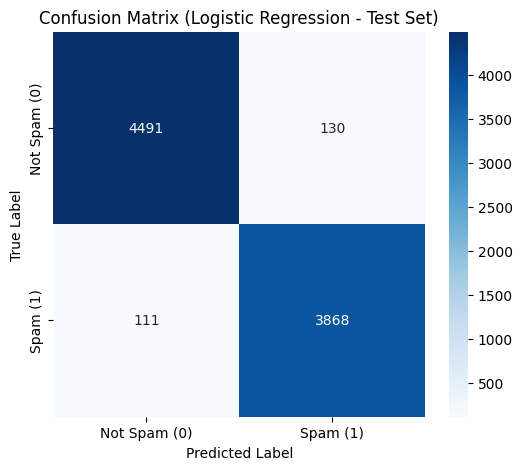

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam (0)', 'Spam (1)'],  
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (Logistic Regression - Test Set)')     
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Cross-Validation Check

In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_combined, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))


Cross-validation accuracies: [0.96976744 0.96872093 0.97104651 0.9694186  0.97383417]
Mean accuracy: 0.9706 ± 0.0018


## Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9406976744186046

Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      4621
           1       0.95      0.92      0.93      3979

    accuracy                           0.94      8600
   macro avg       0.94      0.94      0.94      8600
weighted avg       0.94      0.94      0.94      8600



In [27]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(nb_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Naive Bayes cross-val accuracies: [0.9372093  0.94209302 0.94465116 0.94046512 0.94720316]
Mean accuracy: 0.9423 ± 0.0034


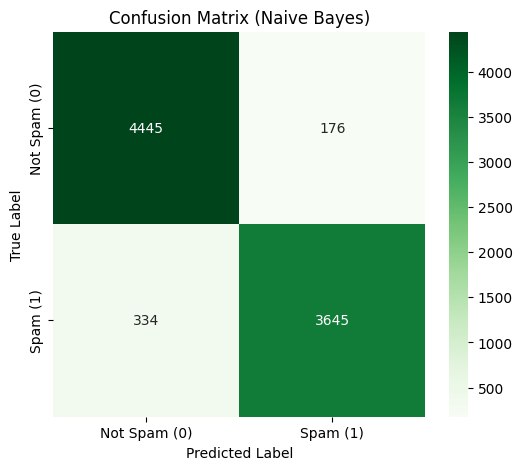

In [28]:
cm_nb = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Not Spam (0)', 'Spam (1)'],
    yticklabels=['Not Spam (0)', 'Spam (1)']
)
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SVM Model

In [29]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(random_state=42)

svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9734883720930233

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      4621
           1       0.97      0.97      0.97      3979

    accuracy                           0.97      8600
   macro avg       0.97      0.97      0.97      8600
weighted avg       0.97      0.97      0.97      8600



In [30]:
train_set = accuracy_score(y_train, svm_model.predict(X_train))
test_set = accuracy_score(y_test, svm_model.predict(X_test))

print("Train accuracy:", train_set)
print("Test set acc:",  test_set)

Train accuracy: 0.9929358411581732
Test set acc: 0.9734883720930233


In [31]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X_combined, y, cv=cv, scoring='accuracy')

print("SVM cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

SVM cross-val accuracies: [0.97302326 0.97406977 0.97465116 0.9744186  0.97557856]
Mean accuracy: 0.9743 ± 0.0008


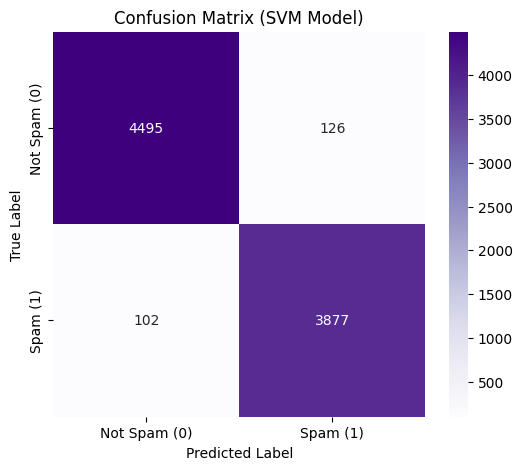

In [32]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Fit model
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.9705813953488373

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4621
           1       0.97      0.97      0.97      3979

    accuracy                           0.97      8600
   macro avg       0.97      0.97      0.97      8600
weighted avg       0.97      0.97      0.97      8600



In [34]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

Naive Bayes cross-val accuracies: [0.97046512 0.96837209 0.9694186  0.96686047 0.96918246]
Mean accuracy: 0.9689 ± 0.0012


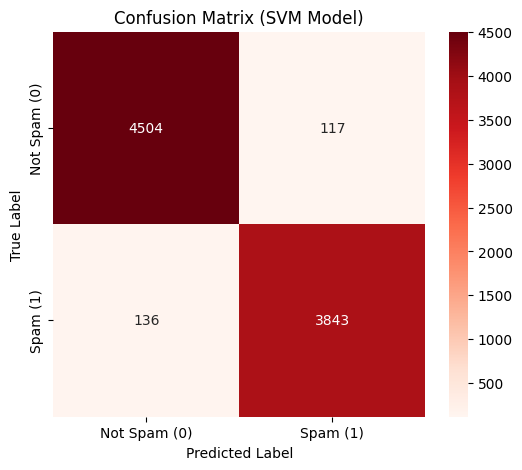

In [35]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Slow comapred to other algorithms

## LGBM

In [36]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

lgbm_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,          # -1 = no limit
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm_model.fit(X_train, y_train)

y_pred_lgbm = lgbm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 15915, number of negative: 18484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529788
[LightGBM] [Info] Number of data points in the train set: 34399, number of used features: 4936
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462659 -> initscore=-0.149643
[LightGBM] [Info] Start training from score -0.149643
Accuracy: 0.9768604651162791

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      4621
           1       0.97      0.98      0.98      3979

    accuracy                           0.98      8600
   macro avg       0.98      0.98      0.98      8600
weighted avg       0.98      0.98      0.98      8600



c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [37]:
# Cross validation check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgbm_model, X_combined, y, cv=cv, scoring='accuracy')

print("Naive Bayes cross-val accuracies:", scores)
print("Mean accuracy: {:.4f} ± {:.4f}".format(scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 15915, number of negative: 18484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529882
[LightGBM] [Info] Number of data points in the train set: 34399, number of used features: 4935
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462659 -> initscore=-0.149643
[LightGBM] [Info] Start training from score -0.149643


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 15915, number of negative: 18484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 531050
[LightGBM] [Info] Number of data points in the train set: 34399, number of used features: 4939
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462659 -> initscore=-0.149643
[LightGBM] [Info] Start training from score -0.149643


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 15915, number of negative: 18484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531488
[LightGBM] [Info] Number of data points in the train set: 34399, number of used features: 4937
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462659 -> initscore=-0.149643
[LightGBM] [Info] Start training from score -0.149643


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 15915, number of negative: 18484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531737
[LightGBM] [Info] Number of data points in the train set: 34399, number of used features: 4940
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462659 -> initscore=-0.149643
[LightGBM] [Info] Start training from score -0.149643


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 15916, number of negative: 18484
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 527866
[LightGBM] [Info] Number of data points in the train set: 34400, number of used features: 4938
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.462674 -> initscore=-0.149581
[LightGBM] [Info] Start training from score -0.149581
Naive Bayes cross-val accuracies: [0.975      0.97604651 0.97802326 0.97360465 0.97755553]
Mean accuracy: 0.9760 ± 0.0016


c:\Users\lle34\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


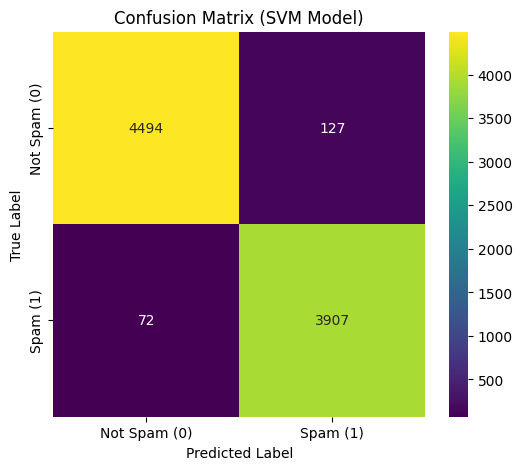

In [38]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Not Spam (0)', 'Spam (1)'],
            yticklabels=['Not Spam (0)', 'Spam (1)'])
plt.title('Confusion Matrix (SVM Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()